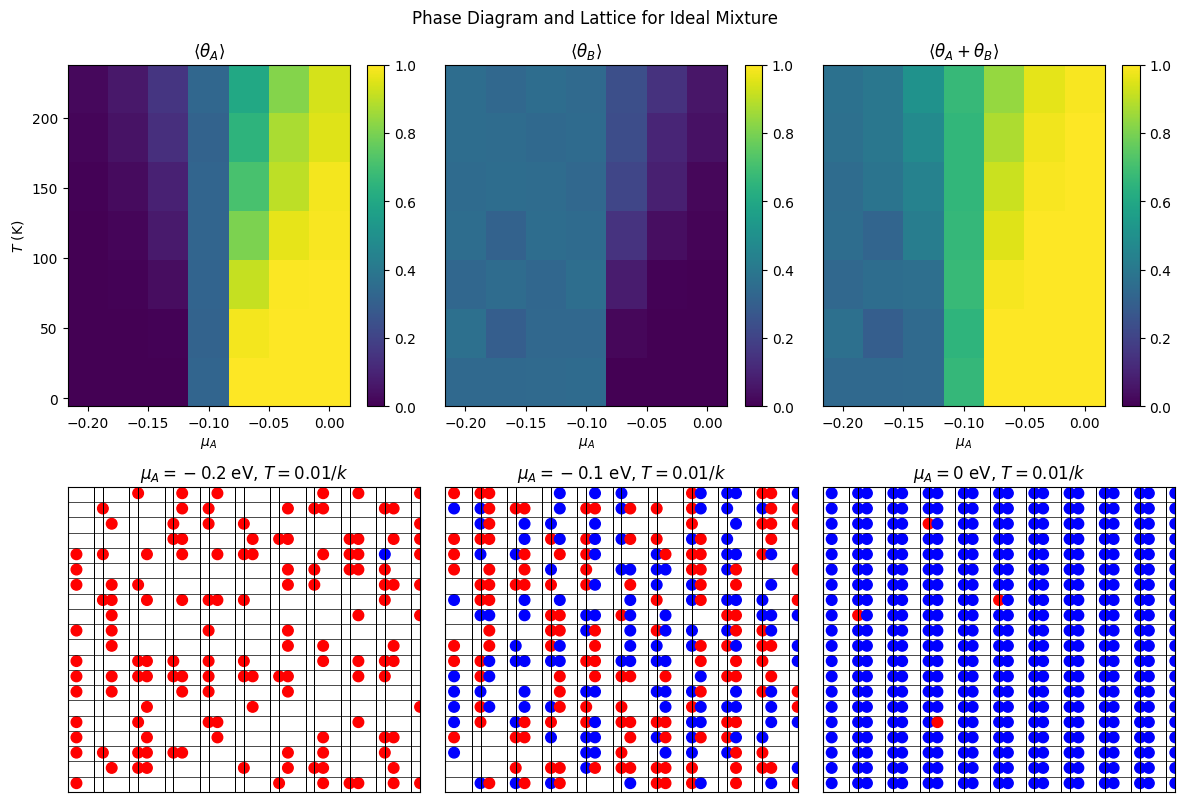

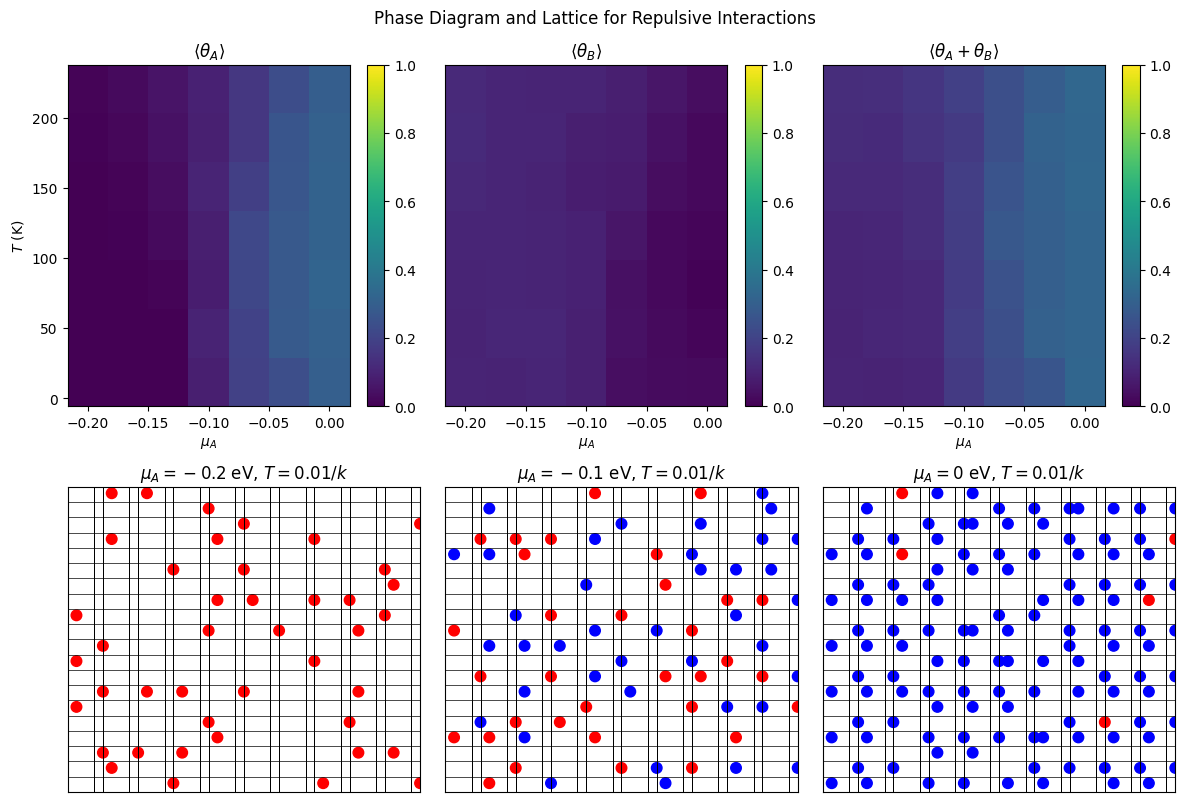

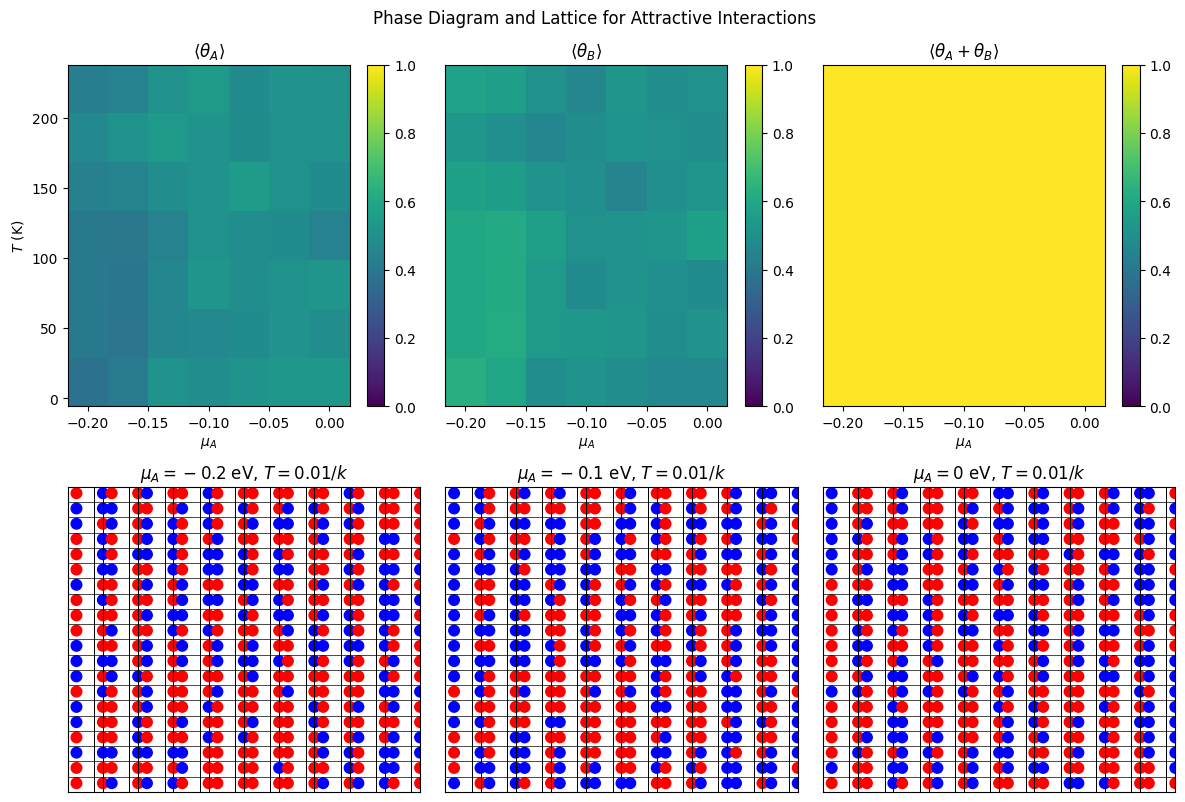

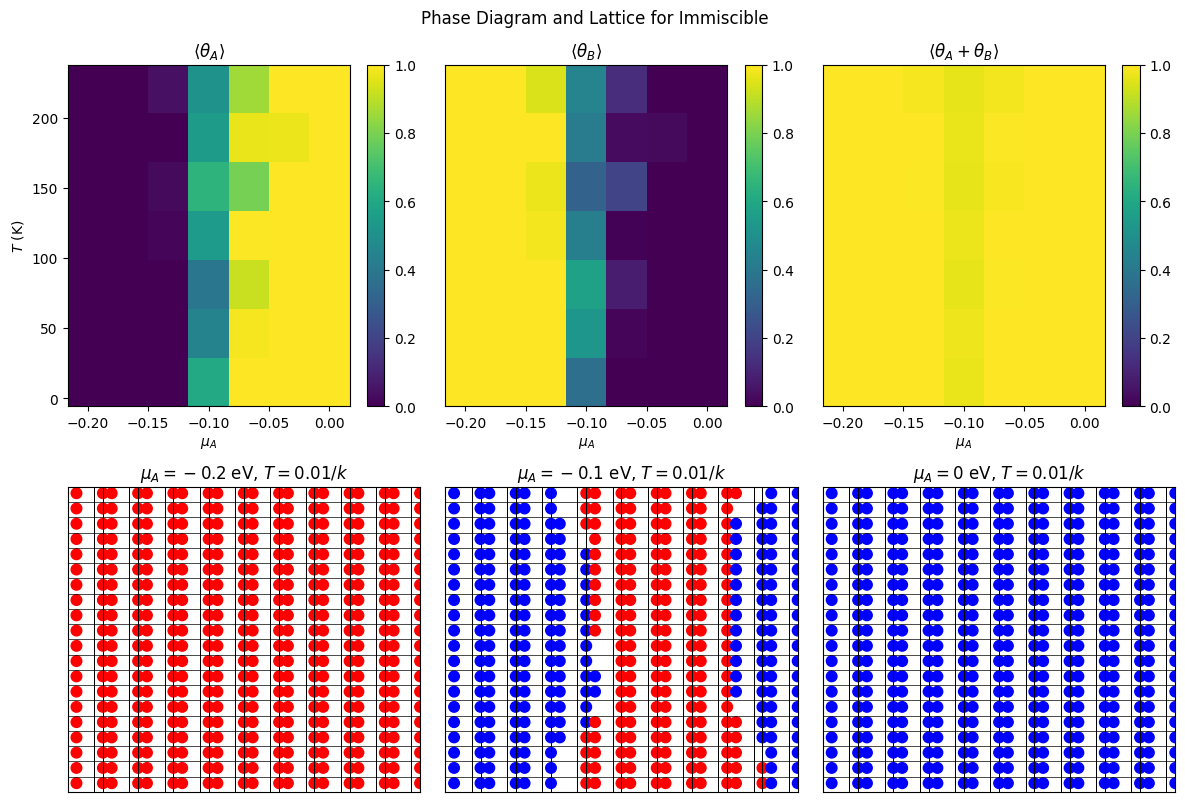

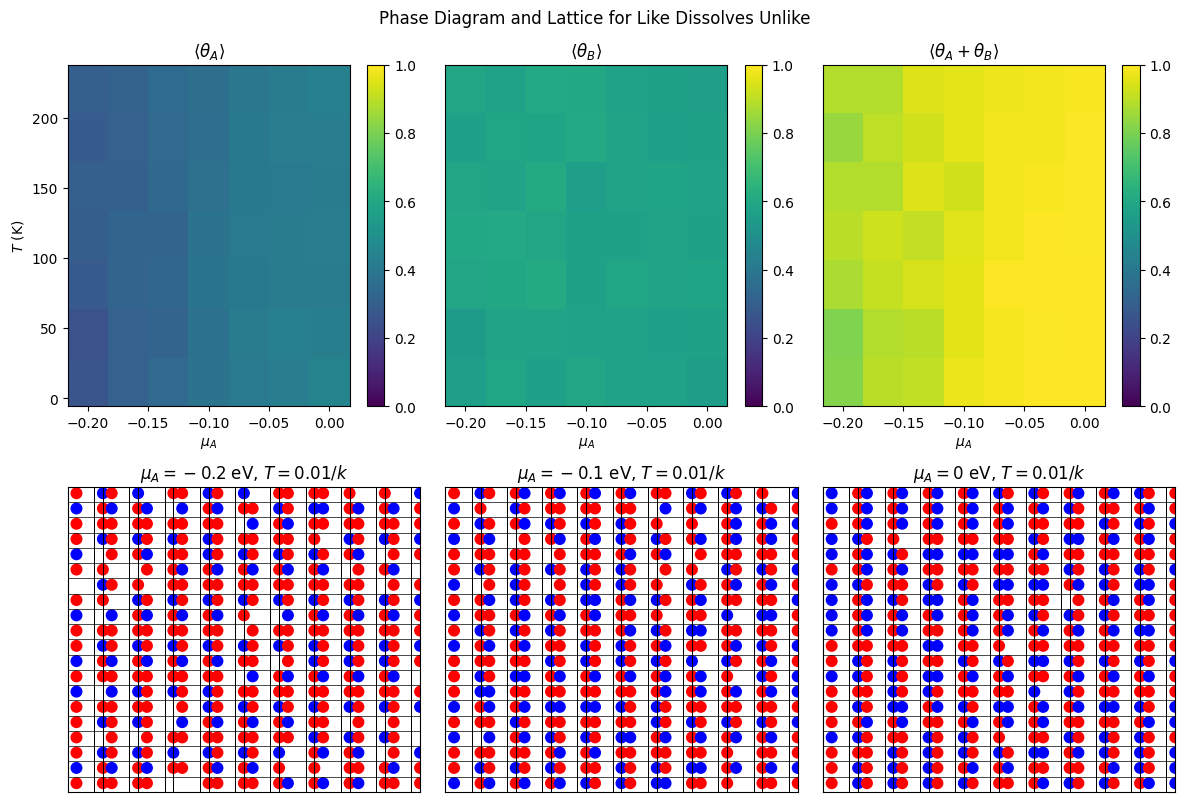

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
lattice_size = 20  # Lattice size (NxN)
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

# Convert T values to Kelvin (assuming T in eV/k_B, where k_B = 8.6173e-5 eV/K)
k_B = 8.6173e-5
Ts_kelvin = Ts / k_B

# Interaction parameters (eV)
interaction_sets = {
    "Ideal Mixture": [-0.1, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next
    "Repulsive Interactions": [-0.1, -0.1, 0.05, 0.05, 0.05, 0.02, 0.02],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next
    "Attractive Interactions": [-0.1, -0.1, -0.05, -0.05, -0.05, -0.03, -0.03],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next
    "Immiscible": [-0.1, -0.1, -0.05, -0.05, 0.05, 0.01, 0.01],  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next
    "Like Dissolves Unlike": [-0.1, -0.1, 0.05, 0.05, -0.05, 0.03, -0.03]  # epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next
}

# Function to initialize lattice
def initialize_lattice(size):
    lattice = np.zeros((size, size))  # 0 represents empty sites
    return lattice

# Function to compute neighbor indices for triangular lattice
def compute_neighbor_indices_triangular(size):
    neighbor_indices = {}
    for x in range(size):
        for y in range(size):
            # Triangular lattice has 6 nearest neighbors, considering the staggered rows
            if y % 2 == 0:
                neighbors = [
                    ((x - 1) % size, y),
                    ((x + 1) % size, y),
                    (x, (y - 1) % size),
                    (x, (y + 1) % size),
                    ((x - 1) % size, (y + 1) % size),
                    ((x - 1) % size, (y - 1) % size)
                ]
            else:
                neighbors = [
                    ((x - 1) % size, y),
                    ((x + 1) % size, y),
                    (x, (y - 1) % size),
                    (x, (y + 1) % size),
                    ((x + 1) % size, (y + 1) % size),
                    ((x + 1) % size, (y - 1) % size)
                ]
            # Add next-nearest neighbors
            next_neighbors = [
                ((x - 2) % size, y),
                ((x + 2) % size, y),
                ((x - 1) % size, (y - 2) % size),
                ((x - 1) % size, (y + 2) % size),
                ((x + 1) % size, (y - 2) % size),
                ((x + 1) % size, (y + 2) % size)
            ]
            neighbor_indices[(x, y)] = (neighbors, next_neighbors)
    return neighbor_indices

# Function to calculate interaction energy
def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next):
    x, y = site
    neighbors, next_neighbors = neighbor_indices[(x, y)]
    interaction_energy = 0
    # Calculate nearest neighbor interactions
    for neighbor in neighbors:
        neighbor_particle = lattice[neighbor]
        if neighbor_particle != 0:
            if particle == 1:  # Particle N
                if neighbor_particle == 1:
                    interaction_energy += epsilon_NN
                else:
                    interaction_energy += epsilon_NH
            else:  # Particle H
                if neighbor_particle == 2:
                    interaction_energy += epsilon_HH
                else:
                    interaction_energy += epsilon_NH
    # Calculate next-nearest neighbor interactions
    for next_neighbor in next_neighbors:
        next_neighbor_particle = lattice[next_neighbor]
        if next_neighbor_particle != 0:
            if particle == 1:  # Particle N
                if next_neighbor_particle == 1:
                    interaction_energy += epsilon_NN_next
            else:  # Particle H
                if next_neighbor_particle == 2:
                    interaction_energy += epsilon_HH_next
    return interaction_energy

# Function to attempt a Monte Carlo move
def attempt_move(lattice, N_N, N_H, N_empty, neighbor_indices, params):
    size = lattice.shape[0]
    N_sites = size * size
    beta = 1 / params['T']
    epsilon_N, epsilon_H, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next, mu_N, mu_H = (
        params['epsilon_N'], params['epsilon_H'], params['epsilon_NN'],
        params['epsilon_HH'], params['epsilon_NH'], params['epsilon_NN_next'],
        params['epsilon_HH_next'], params['mu_N'], params['mu_H']
    )

    if random.random() < 0.5:  # Attempt to add a particle
        if N_empty == 0:
            return N_N, N_H, N_empty
        site = random.choice(np.argwhere(lattice == 0))
        particle = random.choice([1, 2])
        if particle == 1:
            mu = mu_N
            epsilon = epsilon_N
            N_s = N_N
        else:
            mu = mu_H
            epsilon = epsilon_H
            N_s = N_H
        delta_E = epsilon + calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next)
        acc_prob = min(1, (N_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = particle
            if particle == 1:
                N_N += 1
            else:
                N_H += 1
            N_empty -= 1
    else:  # Removing a particle
        if N_sites - N_empty == 0:
            return N_N, N_H, N_empty
        site = random.choice(np.argwhere(lattice != 0))
        particle = lattice[tuple(site)]
        if particle == 1:
            mu = mu_N
            epsilon = epsilon_N
            N_s = N_N
        else:
            mu = mu_H
            epsilon = epsilon_H
            N_s = N_H
        delta_E = -epsilon - calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_NN, epsilon_HH, epsilon_NH, epsilon_NN_next, epsilon_HH_next)
        acc_prob = min(1, (N_s / (N_empty + 1)) * np.exp(-beta * (delta_E + mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = 0
            if particle == 1:
                N_N -= 1
            else:
                N_H -= 1
            N_empty += 1
    return N_N, N_H, N_empty

# Function to plot lattice configuration for triangular lattice
def plot_lattice_triangular(ax, lattice, title):
    size = lattice.shape[0]
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    # Plot lattice as circles in a triangular arrangement
    for x in range(size):
        for y in range(size):
            x_offset = 0.5 * (y % 2)  # Offset every other row
            if lattice[x, y] == 1:
                ax.add_patch(plt.Circle((y + x_offset, x * np.sqrt(3) / 2), 0.3, color='blue'))
            elif lattice[x, y] == 2:
                ax.add_patch(plt.Circle((y + x_offset, x * np.sqrt(3) / 2), 0.3, color='red'))
    # Add grid lines
    for x in range(size + 1):
        for y in range(size + 1):
            x_offset = 0.5 * (y % 2)
            ax.plot([y - 0.5 + x_offset, y - 0.5 + x_offset], [-0.5, size * np.sqrt(3) / 2 - 0.5], color='black', lw=0.5)
    for y in range(size + 1):
        ax.plot([-0.5, size - 0.5], [y * np.sqrt(3) / 2 - 0.5, y * np.sqrt(3) / 2 - 0.5], color='black', lw=0.5)
    ax.set_xlim(-0.5, size - 0.5)
    ax.set_ylim(-0.5, size * np.sqrt(3) / 2 - 0.5)
    ax.set_aspect('equal')

# Function to run the simulation
def run_simulation(size, n_steps, params):
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices_triangular(size)
    N_sites = size * size
    N_N, N_H, N_empty = 0, 0, N_sites
    coverage_N = np.zeros(n_steps)
    coverage_H = np.zeros(n_steps)

    for step in range(n_steps):
        N_N, N_H, N_empty = attempt_move(lattice, N_N, N_H, N_empty, neighbor_indices, params)
        coverage_N[step] = N_N / N_sites
        coverage_H[step] = N_H / N_sites

    return lattice, coverage_N, coverage_H

# Run the simulation with triangular lattice
np.random.seed(42)

final_lattice = np.zeros((len(mus_A), len(Ts), lattice_size, lattice_size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))

for interaction_name, interaction_params in interaction_sets.items():
    for i, mu_A in enumerate(mus_A):
        for j, T in enumerate(Ts):
            params = {
                'epsilon_N': interaction_params[0],
                'epsilon_H': interaction_params[1],
                'epsilon_NN': interaction_params[2],
                'epsilon_HH': interaction_params[3],
                'epsilon_NH': interaction_params[4],
                'epsilon_NN_next': interaction_params[5],
                'epsilon_HH_next': interaction_params[6],
                'mu_N': mu_A,
                'mu_H': -0.1,
                'T': T
            }
            neighbor_indices = compute_neighbor_indices_triangular(lattice_size)
            lattice, coverage_A, coverage_B = run_simulation(lattice_size, n_steps, params)
            final_lattice[i, j] = lattice
            mean_coverage_A[i, j] = np.mean(coverage_A[-1000:])
            mean_coverage_B[i, j] = np.mean(coverage_B[-1000:])

    # Plot the T-mu_A phase diagram
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.ravel()

    # Mean coverage of A
    cax1 = axs[0].pcolormesh(mus_A, Ts_kelvin, mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title(r'$\langle \theta_A \rangle$')
    axs[0].set_xlabel(r'$\mu_A$')
    axs[0].set_ylabel(r'$T$ (K)')
    fig.colorbar(cax1, ax=axs[0])

    # Mean coverage of B
    cax2 = axs[1].pcolormesh(mus_A, Ts_kelvin, mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title(r'$\langle \theta_B \rangle$')
    axs[1].set_xlabel(r'$\mu_A$')
    axs[1].set_yticks([])
    fig.colorbar(cax2, ax=axs[1])

    # Mean total coverage
    cax3 = axs[2].pcolormesh(mus_A, Ts_kelvin, mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title(r'$\langle \theta_A + \theta_B \rangle$')
    axs[2].set_xlabel(r'$\mu_A$')
    axs[2].set_yticks([])
    fig.colorbar(cax3, ax=axs[2])

    # Plot the final lattice configuration as circles
    plot_indices = [(0, 3), (3, 3), (6, 3)]  # (mu_A index, T index)
    plot_titles = [r'$\mu_A = -0.2$ eV, $T = 0.01 / k$', r'$\mu_A = -0.1$ eV, $T = 0.01 / k$', r'$\mu_A = 0$ eV, $T = 0.01 / k$']

    for idx, (mu_idx, T_idx) in enumerate(plot_indices):
        ax = axs[3 + idx]
        lattice_plot = final_lattice[mu_idx, T_idx]
        plot_lattice_triangular(ax, lattice_plot, plot_titles[idx])

    plt.tight_layout()
    plt.suptitle(f"Phase Diagram and Lattice for {interaction_name}", y=1.02)
    plt.show()